## Sampling hyperspheres with numpy 

In mathematics, a [hypersphere](https://en.wikipedia.org/wiki/N-sphere) is the generalization of a sphere to $N$ dimensions. 
This is a frequently useful concept in physics, where the [phase space](https://en.wikipedia.org/wiki/Phase_space) of a physical 
system in general has a dimensionality **much** higher than the familiar 3 spatial dimensions human beings are used to reasoning about. 
For example, the motion of a _single particle_ is most generally defined by no less than six independent coordinates: 
$(x, y, z, v_x, v_y, v_z)$. In a system of $N$ independent particles, we may have to deal with as many as $6N$ simultaneous dimensions!

In particular, for my research, I am interested in resolving the motion of a beam of charged particles evolving according to the rules of
[Vlasov dynamics](https://en.wikipedia.org/wiki/Vlasov_equation), something accelerator physicists refer to as _space charge_. Put in terms
of Physics 101, charged particles push on each other with a repulsive force, so when you get a whole bunch of them together (like the intense
beam of protons I am studying), they get A Bit Unhappy™. In accelerator physics, we use quadrupole magnets to overcome this repulsion with a
force that 'focuses' the particles. The combined back-and-forth of this repulsion and focusing of many particles going around in a particle
accelerator makes for quite a complex problem. Happily, there are some known analytical formulae for beams that let us reason about these 
beams, namely the **Kapchinskij-Vladimirskij (KV)** and **waterbag** distributions. It turns out that these distributions are equivalent to
_uniform distributions over the surface and interior (respectively) of a 4-dimensional hypersphere_, the four dimensions corresponding to the
transverse degrees of freedom of the beam (i.e. the position and momentum in the plane parallel to the direction motion).

So, I want to shove some beams generated using these distributions into my cyclotron simulations, and see how they behave to get a feel for 
the space charge effect in this machine. This means I have to sample the 4-sphere! It turns out there is a pretty straightforward and elegant
way to do this with `numpy`!

In [1]:
import numpy as np
import scipy.special

def uniform_sample_hypersphere(N, M, surface=True):
    """
    Uniformly sample M points from the unit N-hypersphere or its interior. 
    
    Parameters
    ----------
    N (int) - dimensionality of the hypersphere
    M (int) - number of samples to draw
    surface (bool) - draw samples from the surface (default) or from the interior
    """
    # first, uniformly sample the *surface* of the unit N-hypersphere
    # the clever trick here: Π_i exp(-xi**2 / 2) = exp(-r**2 / 2) is *only* a function
    # of distance, so it *must* be uniform over the hypersurface.
    # cheers to https://stackoverflow.com/questions/5408276/sampling-uniformly-distributed-random-points-inside-a-spherical-volume/23785326#23785326
    # (and to energizer for directing me to it). This is due to an algorithm mentioned
    # by Knuth, see also: http://www-alg.ist.hokudai.ac.jp/~jan/randsphere.pdf
    X = np.random.normal(loc=0, scale=1, size=N*M).reshape((M, N)) 
    X /= np.linalg.norm(X, axis=1)[:, np.newaxis]

    if not surface:
        # now just scale by U**1/N
        # credit: https://mathoverflow.net/a/309568
        radii = (np.random.uniform(size=M))**(1./N)
        X *= radii[:, np.newaxis]  # X should now uniformly sample the N-hypersphere's interior
    return X

Text(0.5, 1.0, 'Distribution of $r^4$ ($\\propto$ volume of enclosing sphere)')

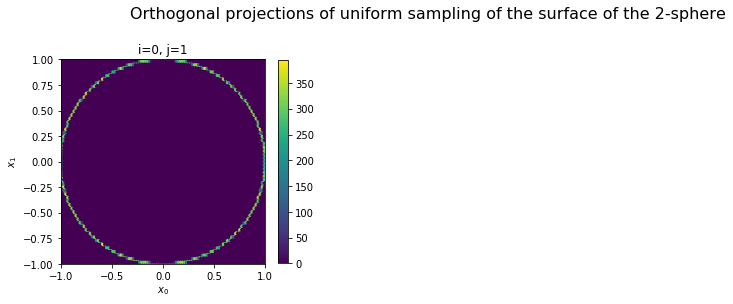

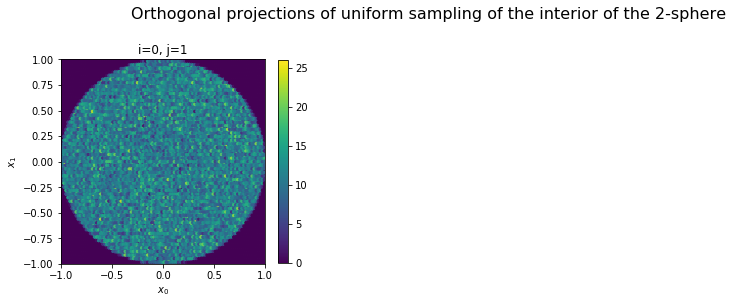

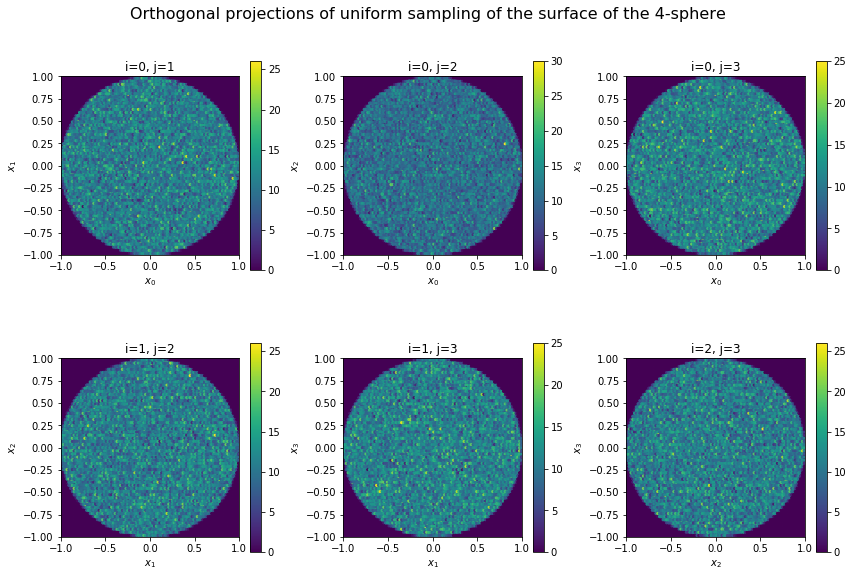

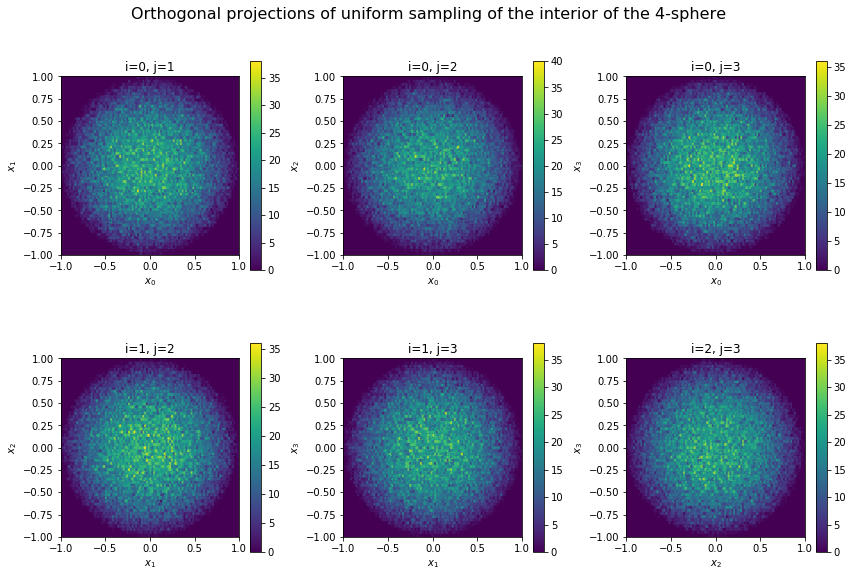

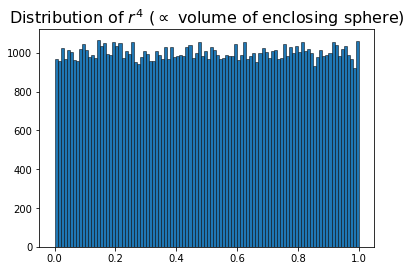

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import itertools
from scipy.special import comb

N = 4
M = 100_000

# sanity check, the 2-sphere is a disc, and very easy to see if we're properly sampling the surface (a circle)
disc_surface_pts = uniform_sample_hypersphere(2, M)
disc_interior_pts = uniform_sample_hypersphere(2, M, surface=False)

surface_pts = uniform_sample_hypersphere(N, M)
interior_pts = uniform_sample_hypersphere(N, M, surface=False)

def plot_projections(pts, hex=True):
    M, N = pts.shape
    Ncomb = comb(N, 2)
    nplt = max(int(1 + Ncomb**.5), 3)
    fig = plt.figure(figsize=(4*nplt, 4*nplt))
    radii = np.linalg.norm(pts, axis=1)
    for num, (i,j) in enumerate(itertools.combinations(range(N), 2), 1):
        ax = plt.subplot(nplt, nplt, num)
        if hex:
            plt.hexbin(pts[:, i], pts[:, j], extent=(-1, 1, -1, 1))
            plt.colorbar(shrink=0.75)
        else:
            plt.plot(pts[:, i], pts[:, j], 'ko', mfc='none', ms=0.5, alpha=0.5)
        ax.set_aspect('equal')
        plt.xlabel(rf'$x_{i}$')
        plt.ylabel(rf'$x_{j}$')
        plt.title(f'i={i}, j={j}')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

    plt.tight_layout()
    return fig

# 2-sphere
plot_projections(disc_surface_pts)
plt.suptitle(f'Orthogonal projections of uniform sampling of the surface of the {2}-sphere', y=1.01, fontsize=16)
plt.tight_layout()

plot_projections(disc_interior_pts)
plt.suptitle(f'Orthogonal projections of uniform sampling of the interior of the {2}-sphere', y=1.01, fontsize=16)
plt.tight_layout()

# 4-sphere
plot_projections(surface_pts)
plt.suptitle(f'Orthogonal projections of uniform sampling of the surface of the {N}-sphere', y=1.01, fontsize=16)
plt.tight_layout()

plot_projections(interior_pts)
plt.suptitle(f'Orthogonal projections of uniform sampling of the interior of the {N}-sphere', y=1.01, fontsize=16)
plt.tight_layout()

plt.figure()
plt.hist(np.linalg.norm(interior_pts, axis=1)**(N), bins=100, edgecolor=(0, 0, 0, 0.5))
plt.title(f'Distribution of $r^{N}$ ($\propto$ volume of enclosing sphere)', fontsize=16)

Text(0.5, 1.0, 'Distribution of $r^3$ ($\\propto$ volume of enclosing sphere)')

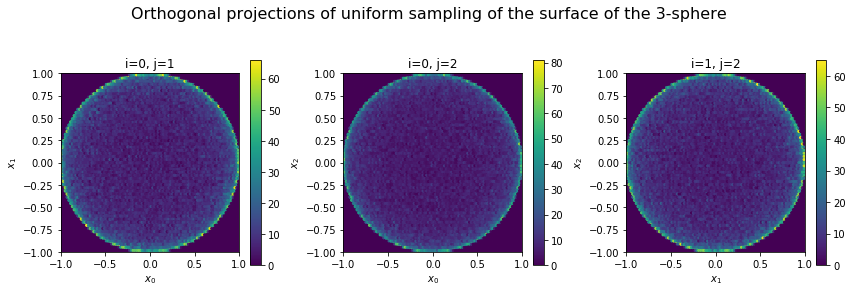

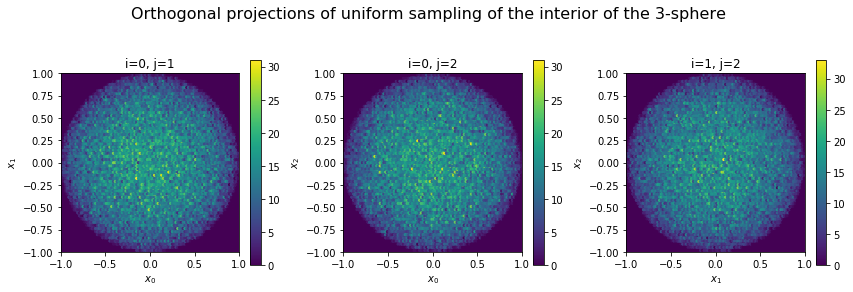

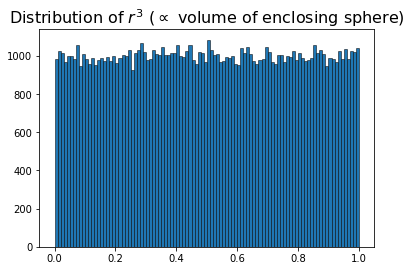

In [11]:
# More sanity checking, let's try the Euclidean sphere

N = 3
M = 100_000
surface_pts = uniform_sample_hypersphere(N, M)
interior_pts = uniform_sample_hypersphere(N, M, surface=False)

plot_projections(surface_pts)
plt.suptitle(f'Orthogonal projections of uniform sampling of the surface of the {N}-sphere', y=1.01, fontsize=16)
plt.tight_layout()

plot_projections(interior_pts)
plt.suptitle(f'Orthogonal projections of uniform sampling of the interior of the {N}-sphere', y=1.01, fontsize=16)
plt.tight_layout()

plt.figure()
plt.hist(np.linalg.norm(interior_pts, axis=1)**(N), bins=100, edgecolor=(0, 0, 0, 0.5))
plt.title(f'Distribution of $r^{N}$ ($\propto$ volume of enclosing sphere)', fontsize=16)